Willa LSTM-01

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM,Dense
from sklearn.preprocessing import MinMaxScaler

from keras.models import load_model

Using TensorFlow backend.
C:\Users\Qhzi_\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Qhzi_\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Qhzi_\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Qhzi_\AppData\Roa

In [2]:
num_companies = 11
num_variables = 42
look_back = 40
forward_days = 15
num_periods = 5

companies_names = ['VNQ','EMB','LQD',
            'MUB','VIG','IVV','EEM',
            'EFA','XLE','SHY','TIP']

In [3]:
data = pd.read_csv('data.csv', index_col=0)

In [4]:
data.head()

,CFE_VIX,CRUDOIL,EEM_MSCIEMERGING,EFA_MSCIEAFE,EMB_USDEMRGBOND,IVV_SP500,LQD_CORPBOND,MUB_MUNIBOND,SHY_1-3USTR,SP500_GSCI,...,EMB_VOL,LQD_VOL,MUB_VOL,VIG_VOL,IVV_VOL,EEM_VOL,EFA_VOL,XLE_VOL,SHY_VOL,TIP_VOL
date,,,,,,,,,,,,,,,,,,,,,
1/8/2008,24.10,96.34,48.2000,26.14,102.197,139.21,106.270,101.85,82.66,620.906,...,0.273570,0.342272,0.163248,0.588243,2.430027,0.672056,0.375007,1.848518,0.122233,0.158335
1/9/2008,25.00,95.68,49.7800,26.48,102.120,141.05,106.050,102.11,82.62,616.887,...,0.234243,0.345803,0.124218,0.506379,1.997616,0.789580,0.301695,1.721589,0.073689,0.034641
1/10/2008,24.42,93.72,50.3667,26.28,102.210,142.04,105.738,101.96,82.62,607.434,...,0.206426,0.342953,0.109681,0.364033,1.117511,0.986725,0.128841,0.637754,0.044497,0.228210
1/11/2008,25.01,92.70,48.9500,25.71,101.838,140.32,106.510,102.09,82.85,605.848,...,0.162948,0.319982,0.105214,0.394360,1.159634,0.886779,0.290207,0.671141,0.115845,0.287785
1/14/2008,24.99,94.21,49.6700,25.91,102.190,141.75,106.070,102.55,82.88,615.283,...,0.156563,0.286197,0.266496,0.358497,1.143866,0.835776,0.302704,0.642441,0.128374,0.452968


In [5]:
assets = ['VNQ_VANGREALEST','EMB_USDEMRGBOND','LQD_CORPBOND',
            'MUB_MUNIBOND','VIG_VANGDIV','IVV_SP500','EEM_MSCIEMERGING',
            'EFA_MSCIEAFE','XLE_ENERGYSPDR','SHY_1-3USTR','TIP_TIPSBOND']
vol = ['VNQ_VOL','EMB_VOL','LQD_VOL','MUB_VOL','VIG_VOL','IVV_VOL','EEM_VOL','EFA_VOL','XLE_VOL','SHY_VOL','TIP_VOL']
macroecon = ['UST_10YR','USFFR','USDRMB','CRUDOIL','CFE_VIX','USDEUR','UST_2YR',
             'SP500_GSCI','USDOIS','CHNGDP','USGDP','EZGDP','US_UNEMP','USDJPY',
             'USDGBP','UIVE_SP500VALUEETF','CHNGDP_Shock','USGDP_Shock','EZGDP_Shock' 'US_UNEMP_Shock',]


In [6]:
scaler = MinMaxScaler()
scl1 = scaler.fit(data)

scaler2 = MinMaxScaler()
scl2 = scaler2.fit(data[assets])

In [7]:
#split in Train and Test
division = len(data) - num_periods*forward_days
test = data[division-look_back:]
train = data[:division]

In [10]:
#Get the data and splits in output Y, by spliting in `n` past days as input X 
#and `m` coming days as Y.
def processData_get_y(data, look_back, forward_days,num_companies,jump):
    Y = []
    for i in range(0,len(data) -look_back -forward_days +1, jump):
        #X.append(data[i:(i+look_back)])
        Y.append(data[(i+look_back):(i+look_back+forward_days)])
    return np.array(Y)

In [11]:
#Get the data and splits in input X , by spliting in `n` past days as input X 
#and `m` coming days as Y.

def processData_get_X(data, look_back, forward_days,num_companies,jump):
    X = []
    for i in range(0,len(data) -look_back -forward_days +1, jump):
        X.append(data[i:(i+look_back)])
        #Y.append(data[(i+look_back):(i+look_back+forward_days)])
    return np.array(X)

In [13]:
#train: if jump = 1, then the 1st X will be day 1~40, the 2nd sample will be day 2~41, and so on; 
#the 1st y will be day 41~55, the 2nd y will be day 42~56,... and so on; therefore we will have overlapping predictions for each X.

df_x = scl1.transform(train.values)
df_y = scl2.transform(train[assets].values)
X = processData_get_X(df_x, look_back, forward_days,num_variables,jump=1)
y = processData_get_y(df_y, look_back, forward_days, num_companies,jump=1)
y = np.array([list(x.ravel()) for x in y])
from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.20, random_state=42)


In [12]:
#test:
df_x = scl1.transform(test.values)
df_y = scl2.transform(test[assets].values)
X_test = processData_get_X(df_x,look_back,forward_days,num_variables,jump=1)
y_test = processData_get_y(df_y, look_back, forward_days,num_companies,jump=1)
y_test = np.array([list(a.ravel()) for a in y_test])


In [16]:
y_test.shape

(61, 165)

In [17]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
es= EarlyStopping(monitor='val_loss', mode ='min', verbose = 1, patience = 3)
mc = ModelCheckpoint('VGG16_tunning.h5', monitor='val_loss', save_best_only = True, mode ='min', verbose = 1)

In [18]:
NUM_NEURONS_FirstLayer = 20
NUM_NEURONS_SecondLayer = 10
EPOCHS = 50

#Build the model
model = Sequential()
model.add(LSTM(NUM_NEURONS_FirstLayer,input_shape=(look_back,num_variables), return_sequences=True))
model.add(LSTM(NUM_NEURONS_SecondLayer,input_shape=(NUM_NEURONS_FirstLayer,1)))
model.add(Dense(forward_days * num_companies))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train,y_train,epochs=EPOCHS,validation_data=(X_validate,y_validate),callbacks = [es, mc],shuffle=True,batch_size=1, verbose=2)


Train on 2264 samples, validate on 566 samples
Epoch 1/50
 - 114s - loss: 0.0195 - val_loss: 0.0053

Epoch 00001: val_loss improved from inf to 0.00532, saving model to VGG16_tunning.h5
Epoch 2/50
 - 112s - loss: 0.0040 - val_loss: 0.0036

Epoch 00002: val_loss improved from 0.00532 to 0.00356, saving model to VGG16_tunning.h5
Epoch 3/50
 - 115s - loss: 0.0027 - val_loss: 0.0021

Epoch 00003: val_loss improved from 0.00356 to 0.00210, saving model to VGG16_tunning.h5
Epoch 4/50
 - 112s - loss: 0.0022 - val_loss: 0.0019

Epoch 00004: val_loss improved from 0.00210 to 0.00189, saving model to VGG16_tunning.h5
Epoch 5/50
 - 116s - loss: 0.0019 - val_loss: 0.0019

Epoch 00005: val_loss improved from 0.00189 to 0.00187, saving model to VGG16_tunning.h5
Epoch 6/50
 - 112s - loss: 0.0017 - val_loss: 0.0016

Epoch 00006: val_loss improved from 0.00187 to 0.00160, saving model to VGG16_tunning.h5
Epoch 7/50
 - 105s - loss: 0.0016 - val_loss: 0.0015

Epoch 00007: val_loss improved from 0.00160 

In [19]:
Xt = model.predict(X_test)
Xt.shape

(61, 165)

In [20]:
def do_inverse_transform(output_result,num_companies = 11):

    #transform to input shape
    original_matrix_format = []
    for result in output_result:
        #do inverse transform by company
        original_matrix_format.append(scl2.inverse_transform([result[x:x+num_companies] for x in range(0, len(result), num_companies)]))
    original_matrix_format = np.array(original_matrix_format)
    
    #restore to original shape
    for i in range(len(original_matrix_format)):
        output_result[i] = original_matrix_format[i].ravel()

    return output_result

In [23]:
def target_by_company(raw_model_output, num_companies):
    matrix_target = [[] for x in range(num_companies)]
    
    for output in raw_model_output:
        for i in range (num_companies):
            for j in range(0,len(output),num_companies):
                matrix_target[i].append(output[i+j])
    return np.array(matrix_target)

In [50]:
#Predicted Value
Yt = do_inverse_transform(y_test)
Pred_Y = target_by_company(Yt, num_companies)
Pred_Y.shape

(11, 915)

In [51]:
#Target Value
Xt = do_inverse_transform(Xt)
Targ_Y = target_by_company(Xt, num_companies)
Targ_Y.shape

(11, 915)

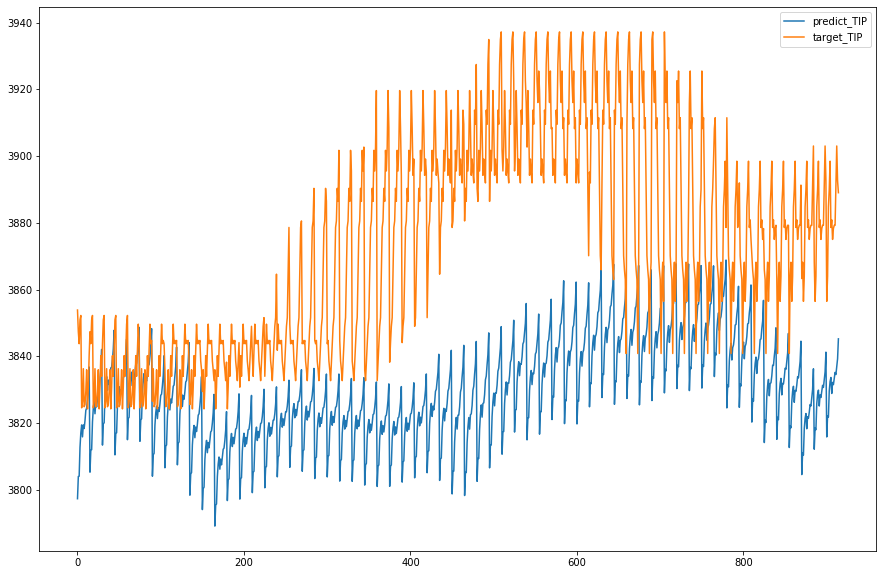

In [52]:

plt.figure(figsize = (15,10))

companies_to_show = [10] #select one of [0,1,2,3] to see only one


for id_company in companies_to_show:
    plt.plot(Targ_Y[id_company], label='predict_{}'.format(companies_names[id_company]))
    plt.plot(Pred_Y[id_company], label='target_{}'.format(companies_names[id_company]))

plt.legend(loc='best')
plt.show()
